# NN Monte Carlo 2
Author: Daniel Carne

Date: 1/1/2025

Description: Single NN for each number of layers for comparison in RNN paper

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load in data and seperate inputs and answers

In [ ]:
dataset_a = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_compileda.txt')
dataset_b = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_compiledb.txt')
dataset = np.concatenate((dataset_a, dataset_b), axis=0)
print(dataset.shape)
input_t = np.zeros((len(dataset[:, 0]), 4))
input_t[:, :] = dataset[:, :4]
# dimensionless mu_a*t and mu_s*t
input_t[:, 1] *= dataset[:, 4]
input_t[:, 2] *= dataset[:, 4]
answers_t = np.zeros((len(dataset[:, 0]), 3))
answers_t[:, 0] = dataset[:, 6] + dataset[:, 7]
answers_t[:, 1] = dataset[:, 8]
answers_t[:, 2] = dataset[:, 9]

(480000, 16)


 Normalize inputs (improve this in future)

In [ ]:
# normalize inputs
input_t2 = input_t.copy()
# refractive index and asymmetry parameter linear norm
input_t2[:, 0] = input_t[:, 0]/2.5
input_t2[:, 3] = input_t[:, 3]
# mu_s*t and mu_a*t logrithmic norm
input_t2[:, 1] = np.log10(input_t[:, 1]+0.0001)
input_t2[:, 1] += 4
input_t2[:, 1] /= 8.69154
input_t2[:, 2] = np.log10(input_t[:, 2]+0.0001)
input_t2[:, 2] += 4
input_t2[:, 2] /= 8.69549
input_t2[:, 3] = -((-input_t2[:, 3]+1)**(1/3))+1

Organize training and test data into 4 sets of tensors by number of layers

In [ ]:
input_1l = np.zeros((0, 4))
input_2l = np.zeros((0, 4))
input_3l = np.zeros((0, 4))
input_4l = np.zeros((0, 4))
answers_1l = np.zeros((0, 3))
answers_2l = np.zeros((0, 3))
answers_3l = np.zeros((0, 3))
answers_4l = np.zeros((0, 3))

for i in range(int(len(input_t2[:, 0])/6)):
  index = i*6
  # get num layers then organize
  if input_t2[index+1, 0] == 0:
    input_1l = np.vstack((input_1l, input_t2[index, :]))
    answers_1l = np.vstack((answers_1l, answers_t[index, :]))
  elif input_t2[index+2, 0] == 0:
    input_2l = np.vstack((input_2l, input_t2[index:index+2, :]))
    answers_2l = np.vstack((answers_2l, answers_t[index, :]))
  elif input_t2[index+3, 0] == 0:
    input_3l = np.vstack((input_3l, input_t2[index:index+3, :]))
    answers_3l = np.vstack((answers_3l, answers_t[index, :]))
  else:
    input_4l = np.vstack((input_4l, input_t2[index:index+4, :]))
    answers_4l = np.vstack((answers_4l, answers_t[index, :]))
# move over to tensor
input_1l = torch.from_numpy(input_1l.astype(np.float32))
input_2l = torch.from_numpy(input_2l.astype(np.float32))
input_3l = torch.from_numpy(input_3l.astype(np.float32))
input_4l = torch.from_numpy(input_4l.astype(np.float32))
answers_1l = torch.from_numpy(answers_1l.astype(np.float32))
answers_2l = torch.from_numpy(answers_2l.astype(np.float32))
answers_3l = torch.from_numpy(answers_3l.astype(np.float32))
answers_4l = torch.from_numpy(answers_4l.astype(np.float32))
# create input tensors (num layers, batch size, num inputs)
input_tensor_1l = torch.zeros(1, len(answers_1l[:, 0]), 4)
input_tensor_2l = torch.zeros(2, len(answers_2l[:, 0]), 4)
input_tensor_3l = torch.zeros(3, len(answers_3l[:, 0]), 4)
input_tensor_4l = torch.zeros(4, len(answers_4l[:, 0]), 4)
for i in range((len(answers_1l[:, 0]))):
  input_tensor_1l[:, i, :] = input_1l[i, :]
for i in range((len(answers_2l[:, 0]))):
  input_tensor_2l[:, i, :] = input_2l[2*i:(2*i+2), :]
for i in range((len(answers_3l[:, 0]))):
  input_tensor_3l[:, i, :] = input_3l[3*i:(3*i+3), :]
for i in range((len(answers_4l[:, 0]))):
  input_tensor_4l[:, i, :] = input_4l[4*i:(4*i+4), :]
print(input_tensor_1l.shape)
print(input_tensor_2l.shape)
print(input_tensor_3l.shape)
print(input_tensor_4l.shape)

torch.Size([1, 19981, 4])
torch.Size([2, 19967, 4])
torch.Size([3, 20055, 4])
torch.Size([4, 19997, 4])


Also import in new validation datasets for 5 and 6 layers

In [ ]:
dataset2 = np.loadtxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/D1.2_validation.txt')
input_t = np.zeros((len(dataset2[:, 0]), 4))
input_t[:, :] = dataset2[:, :4]
# dimensionless mu_a*t and mu_s*t
input_t[:, 1] *= dataset2[:, 4]
input_t[:, 2] *= dataset2[:, 4]
answers_t = np.zeros((len(dataset2[:, 0]), 3))
answers_t[:, 0] = dataset2[:, 6] + dataset2[:, 7]
answers_t[:, 1] = dataset2[:, 8]
answers_t[:, 2] = dataset2[:, 9]

input_5l = np.zeros((0, 4))
input_6l = np.zeros((0, 4))
answers_5l = np.zeros((0, 3))
answers_6l = np.zeros((0, 3))

# normalize inputs
input_t2 = input_t.copy()
# refractive index and asymmetry parameter linear norm
input_t2[:, 0] = input_t[:, 0]/np.max(input_t[:, 0])
input_t2[:, 3] = input_t[:, 3]/np.max(input_t[:, 3])
# mu_s*t and mu_a*t logrithmic norm
input_t2[:, 1] = np.log10(input_t[:, 1]+0.0001)
input_t2[:, 1] += 4
input_t2[:, 1] /= np.max(input_t2[:, 1])
input_t2[:, 2] = np.log10(input_t[:, 2]+0.0001)
input_t2[:, 2] += 4
input_t2[:, 2] /= np.max(input_t2[:, 2])
input_t2[:, 3] = -((-input_t2[:, 3]+1)**(1/3))+1

for i in range(int(len(input_t2[:, 0])/6)):
  index = i*6
  # get num layers then organize
  if input_t2[index+5, 0] == 0:
    input_5l = np.vstack((input_5l, input_t2[index:index+5, :]))
    answers_5l = np.vstack((answers_5l, answers_t[index, :]))
  else:
    input_6l = np.vstack((input_6l, input_t2[index:index+6, :]))
    answers_6l = np.vstack((answers_6l, answers_t[index, :]))
# move over to tensor
input_5l = torch.from_numpy(input_5l.astype(np.float32))
input_6l = torch.from_numpy(input_6l.astype(np.float32))
answers_5l = torch.from_numpy(answers_5l.astype(np.float32))
answers_6l = torch.from_numpy(answers_6l.astype(np.float32))
# create input tensors (num layers, batch size, num inputs)
input_tensor_5l = torch.zeros(5, len(answers_5l[:, 0]), 4)
input_tensor_6l = torch.zeros(6, len(answers_6l[:, 0]), 4)
for i in range((len(answers_5l[:, 0]))):
  input_tensor_5l[:, i, :] = input_5l[5*i:(5*i+5), :]
for i in range((len(answers_6l[:, 0]))):
  input_tensor_6l[:, i, :] = input_6l[6*i:(6*i+6), :]
input_tensor_5l_test = input_tensor_5l.narrow(1, 0, 1000)
input_tensor_6l_test = input_tensor_6l.narrow(1, 0, 1000)
answer_tensor_5l_test = answers_5l.narrow(0, 0, 1000)
answer_tensor_6l_test = answers_6l.narrow(0, 0, 1000)

Split into train (40,000) and test (4,000) datasets

In [ ]:
# randomize tensors indices
np.random.seed(128)

input_tensor_1l_rand = torch.zeros_like(input_tensor_1l)
input_tensor_2l_rand = torch.zeros_like(input_tensor_2l)
input_tensor_3l_rand = torch.zeros_like(input_tensor_3l)
input_tensor_4l_rand = torch.zeros_like(input_tensor_4l)
answers_1l_rand = torch.zeros_like(answers_1l)
answers_2l_rand = torch.zeros_like(answers_2l)
answers_3l_rand = torch.zeros_like(answers_3l)
answers_4l_rand = torch.zeros_like(answers_4l)

rand1 = np.arange(19981)
np.random.shuffle(rand1)
for i in range(19981):
  input_tensor_1l_rand[:, rand1[i], :] = input_tensor_1l[:, i, :]
  answers_1l_rand[rand1[i], :] = answers_1l[i, :]
rand2 = np.arange(19967)
np.random.shuffle(rand2)
for i in range(19967):
  input_tensor_2l_rand[:, rand2[i], :] = input_tensor_2l[:, i, :]
  answers_2l_rand[rand2[i], :] = answers_2l[i, :]
rand3 = np.arange(20055)
np.random.shuffle(rand3)
for i in range(20055):
  input_tensor_3l_rand[:, rand3[i], :] = input_tensor_3l[:, i, :]
  answers_3l_rand[rand3[i], :] = answers_3l[i, :]
rand4 = np.arange(19997)
np.random.shuffle(rand4)
for i in range(19997):
  input_tensor_4l_rand[:, rand4[i], :] = input_tensor_4l[:, i, :]
  answers_4l_rand[rand4[i], :] = answers_4l[i, :]

# split data to train and test
## PREVIOUSLY 60,000 AND 4,500
input_tensor_1l_train_temp = input_tensor_1l_rand.narrow(1, 0, 18720)
input_tensor_2l_train_temp = input_tensor_2l_rand.narrow(1, 0, 18720)
input_tensor_3l_train_temp = input_tensor_3l_rand.narrow(1, 0, 18720)
input_tensor_4l_train_temp = input_tensor_4l_rand.narrow(1, 0, 18720)
answer_tensor_1l_train = answers_1l_rand.narrow(0, 0, 18720)
answer_tensor_2l_train = answers_2l_rand.narrow(0, 0, 18720)
answer_tensor_3l_train = answers_3l_rand.narrow(0, 0, 18720)
answer_tensor_4l_train = answers_4l_rand.narrow(0, 0, 18720)
input_tensor_1l_test_temp = input_tensor_1l_rand.narrow(1, 18720, 1000)
input_tensor_2l_test_temp = input_tensor_2l_rand.narrow(1, 18720, 1000)
input_tensor_3l_test_temp = input_tensor_3l_rand.narrow(1, 18720, 1000)
input_tensor_4l_test_temp = input_tensor_4l_rand.narrow(1, 18720, 1000)
answer_tensor_1l_test = answers_1l_rand.narrow(0, 18720, 1000)
answer_tensor_2l_test = answers_2l_rand.narrow(0, 18720, 1000)
answer_tensor_3l_test = answers_3l_rand.narrow(0, 18720, 1000)
answer_tensor_4l_test = answers_4l_rand.narrow(0, 18720, 1000)

Unfold layers for all in one input

In [ ]:
# 1 layer
input_tensor_1l_train = torch.zeros(18720, 4)
input_tensor_1l_test = torch.zeros(1000, 4)
for i in range(1):
  input_tensor_1l_train[:, i*4:((i+1)*4)] = input_tensor_1l_train_temp[i, :, :]
  input_tensor_1l_test[:, i*4:((i+1)*4)] = input_tensor_1l_test_temp[i, :, :]
# 2 layers
input_tensor_2l_train = torch.zeros(18720, 8)
input_tensor_2l_test = torch.zeros(1000, 8)
for i in range(2):
  input_tensor_2l_train[:, i*4:((i+1)*4)] = input_tensor_2l_train_temp[i, :, :]
  input_tensor_2l_test[:, i*4:((i+1)*4)] = input_tensor_2l_test_temp[i, :, :]
# 3 layers
input_tensor_3l_train = torch.zeros(18720, 12)
input_tensor_3l_test = torch.zeros(1000, 12)
for i in range(3):
  input_tensor_3l_train[:, i*4:((i+1)*4)] = input_tensor_3l_train_temp[i, :, :]
  input_tensor_3l_test[:, i*4:((i+1)*4)] = input_tensor_3l_test_temp[i, :, :]
# 4 layers
input_tensor_4l_train = torch.zeros(18720, 16)
input_tensor_4l_test = torch.zeros(1000, 16)
for i in range(4):
  input_tensor_4l_train[:, i*4:((i+1)*4)] = input_tensor_4l_train_temp[i, :, :]
  input_tensor_4l_test[:, i*4:((i+1)*4)] = input_tensor_4l_test_temp[i, :, :]

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_layer, hidden_layer2, output_size):
    super(RNN, self).__init__()
    self.m2o = nn.Linear(hidden_layer2, output_size)
    self.i2l1 = nn.Linear(input_size, hidden_layer)
    self.l1l2 = nn.Linear(hidden_layer, hidden_layer)
    self.l2l3 = nn.Linear(hidden_layer, hidden_layer2)
    self.activ = nn.ReLU()

  def forward(self, input_tensor):
    mid1 = self.i2l1(input_tensor)
    mid1 = self.activ(mid1)
    mid2 = self.l1l2(mid1)
    mid2 = self.activ(mid2)
    mid3 = self.l2l3(mid2)
    mid3 = self.activ(mid3)
    output = self.m2o(mid3)
    return output



In [ ]:
def train(rnn, input_tensor1, answer_tensor1, criterion, optimizer, batch_size, device):
  rnn.train()
  input_tensor1 = input_tensor1.to(device)
  answer_tensor1 = answer_tensor1.to(device)

  optimizer.zero_grad()
  # feedforward
  output1 = rnn.forward(input_tensor1)

  loss = criterion(output1, answer_tensor1)
  loss.backward()
  optimizer.step()
  return output1, loss.item()

In [ ]:
def test(rnn, input_tensor, answer_tensor, criterion, optimizer, batch_size, device):
  rnn.eval()
  input_tensor = input_tensor.to(device)
  answer_tensor = answer_tensor.to(device)
  # get initial hidden state
  output1 = rnn.forward(input_tensor)

  loss = criterion(output1, answer_tensor)
  return output1, loss.item()

Run to train RNN

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024

# output is R, A, T
output_size = 3
batch_size = 585
batch_size_test = 1240
num_batches = int(18720/batch_size)
epochs = 1000

rnn = RNN(input_dim, hidden_layer, hidden_layer2, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on: " + str(device))
rnn = rnn.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
current_loss_train = 0
current_loss_test = 0
loss_plot_test = np.zeros(epochs)
loss_plot_train = np.zeros(epochs*num_batches)
x_axis = np.linspace(0, epochs, num=epochs*num_batches)


for epoch in range(epochs):
  for batch in range(num_batches):
    # one batch from each layer
    output, loss = train(rnn, input_tensor_1l_train[batch_size*batch:(batch_size*(batch+1)), :], answer_tensor_1l_train[batch_size*batch:(batch_size*(batch+1)), :], criterion, optimizer, batch_size, device)
    current_loss_train += loss
    loss_plot_train[batch + epoch*num_batches] = current_loss_train
    current_loss_train = 0
  # validation
  output, loss = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)
  current_loss_test += loss

  print(epoch, "/", epochs, "Val loss:", current_loss_test)
  loss_plot_test[epoch] = current_loss_test
  current_loss_test = 0



Training on: cuda
0 / 1000 Val loss: 0.030489347875118256
1 / 1000 Val loss: 0.014242489822208881
2 / 1000 Val loss: 0.00857547577470541
3 / 1000 Val loss: 0.005897488910704851
4 / 1000 Val loss: 0.003872124245390296
5 / 1000 Val loss: 0.0023509846068918705
6 / 1000 Val loss: 0.001411503297276795
7 / 1000 Val loss: 0.0009289028821513057
8 / 1000 Val loss: 0.0006488139042630792
9 / 1000 Val loss: 0.0004769889055751264
10 / 1000 Val loss: 0.0003677746281027794
11 / 1000 Val loss: 0.000299190724035725
12 / 1000 Val loss: 0.00025236920919269323
13 / 1000 Val loss: 0.00021730863954871893
14 / 1000 Val loss: 0.0001888750120997429
15 / 1000 Val loss: 0.00016495358431711793
16 / 1000 Val loss: 0.00014481935068033636
17 / 1000 Val loss: 0.00012914740364067256
18 / 1000 Val loss: 0.0001182790074381046
19 / 1000 Val loss: 0.00011055367212975398
20 / 1000 Val loss: 0.00010263443982694298
21 / 1000 Val loss: 9.39573219511658e-05
22 / 1000 Val loss: 8.637701830593869e-05
23 / 1000 Val loss: 8.060028

Save weights and biases

In [ ]:
w1 = rnn.i2l1.weight.cpu().detach().numpy()
w2 = rnn.l1l2.weight.cpu().detach().numpy()
w3 = rnn.l2l3.weight.cpu().detach().numpy()
w_output = rnn.m2o.weight.cpu().detach().numpy()
b1 = rnn.i2l1.bias.cpu().detach().numpy()
b2 = rnn.l1l2.bias.cpu().detach().numpy()
b3 = rnn.l2l3.bias.cpu().detach().numpy()
b_output = rnn.m2o.bias.cpu().detach().numpy()


np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w1_1layer.txt', w1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w2_1layer.txt', w2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w3_1layer.txt', w3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/wo_1layer.txt', w_output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b1_1layer.txt', b1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b2_1layer.txt', b2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b3_1layer.txt', b3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/bo_1layer.txt', b_output)

Good model? Save it

In [ ]:
torch.save(rnn.state_dict(), '/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')

Plot predicted R vs actual R

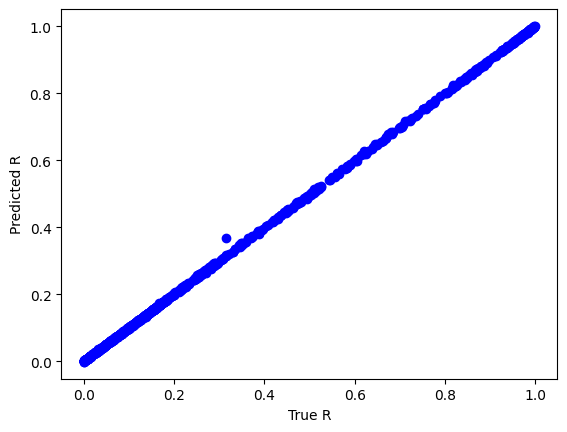

In [ ]:
output1, loss1 = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)

output = output1.to('cpu').detach().numpy()
answer = answer_tensor_1l_test.to('cpu').detach().numpy()
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output1_plainNN.txt', output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer1_plainNN.txt', answer)


plt.plot(answer[:, 0], output[:, 0], "bo")
plt.ylabel('Predicted R')
plt.xlabel('True R')

plt.show()

Load and run saved RNN

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024
hidden_size = 16
# output is R, A, T
output_size = 3
batch_size = 585
batch_size_test = 1000
num_batches = int(18720/batch_size)
epochs = 1000

rnn = RNN(input_dim, hidden_layer, hidden_layer2, hidden_size, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on: " + str(device))
rnn = rnn.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
current_loss_train = 0
current_loss_test = 0
loss_plot_test = np.zeros(epochs)
loss_plot_train = np.zeros(epochs*num_batches)
x_axis = np.linspace(0, epochs, num=epochs*num_batches)


state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')

rnn.load_state_dict(state_dict)


output1, loss1 = test(rnn, input_tensor_1l_test, answer_tensor_1l_test, criterion, optimizer, batch_size_test, device)
output2, loss2 = test(rnn, input_tensor_2l_test, answer_tensor_2l_test, criterion, optimizer, batch_size_test, device)
output3, loss3 = test(rnn, input_tensor_3l_test, answer_tensor_3l_test, criterion, optimizer, batch_size_test, device)
output4, loss4 = test(rnn, input_tensor_4l_test, answer_tensor_4l_test, criterion, optimizer, batch_size_test, device)
output5, loss5 = test(rnn, input_tensor_5l_test, answer_tensor_5l_test, criterion, optimizer, batch_size_test, device)
output6, loss6 = test(rnn, input_tensor_6l_test, answer_tensor_6l_test, criterion, optimizer, batch_size_test, device)
print(loss1, loss2, loss3, loss4, loss5, loss6)
output1 = output1.to('cpu').detach().numpy()
output2 = output2.to('cpu').detach().numpy()
output3 = output3.to('cpu').detach().numpy()
output4 = output4.to('cpu').detach().numpy()
output5 = output5.to('cpu').detach().numpy()
output6 = output6.to('cpu').detach().numpy()
answer1 = answer_tensor_1l_test.to('cpu').detach().numpy()
answer2 = answer_tensor_2l_test.to('cpu').detach().numpy()
answer3 = answer_tensor_3l_test.to('cpu').detach().numpy()
answer4 = answer_tensor_4l_test.to('cpu').detach().numpy()
answer5 = answer_tensor_5l_test.to('cpu').detach().numpy()
answer6 = answer_tensor_6l_test.to('cpu').detach().numpy()
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output1_RNN.txt', output1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output2_RNN.txt', output2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output3_RNN.txt', output3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output4_RNN.txt', output4)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output5_RNN.txt', output5)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/output6_RNN.txt', output6)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer1_RNN.txt', answer1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer2_RNN.txt', answer2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer3_RNN.txt', answer3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer4_RNN.txt', answer4)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer5_RNN.txt', answer5)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/answer6_RNN.txt', answer6)

Training on: cuda
3.167288923577871e-06 1.342157611361472e-05 1.3006816516281106e-05 9.957088877854403e-06 1.8602457203087397e-05 1.6610361853963695e-05


Save weights and biases to numpy array

In [ ]:
np.random.seed(128)
torch.manual_seed(128)
input_dim = 4
# hyperparameters to tune
hidden_layer = 1024
hidden_layer2 = 1024
hidden_size = 16
# output is R, A, T
output_size = 3
batch_size = 585
batch_size_test = 1000
num_batches = int(18720/batch_size)
epochs = 1000
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/rnn_1.6.pth')
rnn = RNN(input_dim, hidden_layer, hidden_layer2, hidden_size, output_size)
rnn.load_state_dict(state_dict)

w1 = rnn.i2l1.weight.cpu().detach().numpy()
w2 = rnn.l1l2.weight.cpu().detach().numpy()
w3 = rnn.l2l3.weight.cpu().detach().numpy()
w_output = rnn.m2o.weight.cpu().detach().numpy()
w_hidden = rnn.m2h.weight.cpu().detach().numpy()
b1 = rnn.i2l1.bias.cpu().detach().numpy()
b2 = rnn.l1l2.bias.cpu().detach().numpy()
b3 = rnn.l2l3.bias.cpu().detach().numpy()
b_output = rnn.m2o.bias.cpu().detach().numpy()
b_hidden = rnn.m2h.bias.cpu().detach().numpy()
print(w_hidden.shape)

np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w1_rnn1.6.txt', w1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w2_rnn1.6.txt', w2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/w3_rnn1.6.txt', w3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/wo_rnn1.6.txt', w_output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/wh_rnn1.6.txt', w_hidden)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b1_rnn1.6.txt', b1)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b2_rnn1.6.txt', b2)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/b3_rnn1.6.txt', b3)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/bo_rnn1.6.txt', b_output)
np.savetxt('/content/drive/My Drive/Colab Notebooks/RNN_Monte_Carlo/bh_rnn1.6.txt', b_hidden)

(16, 1024)
